In [103]:
import tensorflow as tf
from tensorflow import saved_model  
from basic_pitch import ICASSP_2022_MODEL_PATH


from basic_pitch import models
from basic_pitch.callbacks import VisualizeCallback
from basic_pitch.constants import DATASET_SAMPLING_FREQUENCY
from basic_pitch.dataset import tf_example_deserialization

model = models.model(no_contours=False)


# model_path = ICASSP_2022_MODEL_PATH
model_path = "../My_models/guitar-slakh-hwd-dagstuhl/model.best"
oldmodel = saved_model.load(str(model_path))
weights = oldmodel.variables
print(weights)
    

ListWrapper([<tf.Variable 'batch_normalization/gamma:0' shape=(1,) dtype=float32, numpy=array([0.02136466], dtype=float32)>, <tf.Variable 'batch_normalization/beta:0' shape=(1,) dtype=float32, numpy=array([0.0595425], dtype=float32)>, <tf.Variable 'batch_normalization/moving_mean:0' shape=(1,) dtype=float32, numpy=array([0.44046393], dtype=float32)>, <tf.Variable 'batch_normalization/moving_variance:0' shape=(1,) dtype=float32, numpy=array([0.04036848], dtype=float32)>, <tf.Variable 'conv2d_1/kernel:0' shape=(3, 39, 8, 8) dtype=float32, numpy=
array([[[[-9.17895511e-02, -1.12470351e-02,  2.15629693e-02, ...,
          -1.00842528e-01, -3.85309719e-02,  4.81682122e-02],
         [ 3.65761146e-02, -5.29248128e-03, -2.26081293e-02, ...,
          -2.63193045e-02,  1.34203695e-02, -4.80795978e-03],
         [-5.86462691e-02,  5.41102560e-03,  4.18395852e-04, ...,
           1.07618244e-02, -1.95188724e-04,  4.94417781e-03],
         ...,
         [-5.31006977e-02,  1.34815825e-02, -6.16684

In [104]:
def crop_and_shift_midi(midi_path, midi_output, duration, song):
    # load MIDI file
    midi_data = pretty_midi.PrettyMIDI(midi_path)
    # get start time and instruments to keep
    start_time, tokeep_instruments, initial_tempo = HWD_DICT[song]    
    # compute end time
    end_time = start_time + duration
    # new midi object to store the cropped and modified MIDI

    cropped_midi = pretty_midi.PrettyMIDI(initial_tempo=initial_tempo)
    
    for idx, instrument in enumerate(midi_data.instruments):
        if idx in tokeep_instruments:
        # new instrument in the cropped MIDI
            new_instrument = pretty_midi.Instrument(program=instrument.program)
            
            for note in instrument.notes:
                if note.start >= start_time and note.end <= end_time:

                    # No more sax notes after 15 seconds in Hakuna
                    if song == 'Hakuna' and idx == 7 and note.start > start_time+15:
                        continue

                    # Shift temporale delle note
                    new_start = note.start - start_time
                    new_end = note.end - start_time
                    # Crea una nuova nota con i tempi shiftati
                    new_note = pretty_midi.Note(
                        pitch=note.pitch,
                        start=new_start,
                        end=new_end,
                        velocity=note.velocity
                    )
                    new_instrument.notes.append(new_note)
                
            # Aggiungi lo strumento al nuovo file MIDI
            cropped_midi.instruments.append(new_instrument)

    # Salva il nuovo file MIDI
    cropped_midi.write(midi_output)
    return

import numpy as np 
import pretty_midi
import librosa
from basic_pitch.constants import (
    ANNOTATION_HOP,
    ANNOTATIONS_BASE_FREQUENCY,
    CONTOURS_BINS_PER_SEMITONE,
    NOTES_BINS_PER_SEMITONE,
)


def create_onset(midi_path):

    # Load MIDI file
    midi_data = pretty_midi.PrettyMIDI(midi_path)
    onsets_indices = np.empty((0, 2))

    # Get onsets indices
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            row = [note.start, note.pitch]
            onsets_indices = np.vstack((onsets_indices, row))
    # Translate from time to frame index
    onsets_indices[:,0] = np.round(onsets_indices[:,0] / ANNOTATION_HOP)

    # Translate from MIDI pitch to frequency bin
    onsets_indices[:,1] = librosa.midi_to_hz(onsets_indices[:,1])
    onsets_indices[:,1] = 12.0 * NOTES_BINS_PER_SEMITONE * np.log2(onsets_indices[:,1] / ANNOTATIONS_BASE_FREQUENCY)
    onsets_indices[:,1] = onsets_indices[:,1]

    # Round to the nearest integer (they are indices)
    onsets_indices = onsets_indices.astype(int)
    # Create onset values
    onset_values = np.ones(onsets_indices.shape[0])
    return onsets_indices, onset_values

def create_notes(midi_path):

    # Load MIDI file
    midi_data = pretty_midi.PrettyMIDI(midi_path)
    note_indices = np.empty((0, 2))

    for instrument in midi_data.instruments:
        for note in instrument.notes:
            start = np.round(note.start / ANNOTATION_HOP)
            end = np.round(note.end / ANNOTATION_HOP)
            # Duration in frames
            duration = int(end - start)
            # Translate from MIDI pitch to frequency bin
            note_bin = librosa.midi_to_hz(note.pitch)
            note_bin = 12.0 * NOTES_BINS_PER_SEMITONE * np.log2(note_bin / ANNOTATIONS_BASE_FREQUENCY)

            for i in range(duration):
                row = [start + i, note_bin]
                note_indices = np.vstack((note_indices, row))

    # Round to the nearest integer (they are indices)
    note_indices = note_indices.astype(int)

    # Create note values
    note_values = np.ones(note_indices.shape[0])
    return note_indices, note_values

def create_contour(midi_path):
    # Load MIDI file
    midi_data = pretty_midi.PrettyMIDI(midi_path)
    note_indices = np.empty((0, 2))

    for instrument in midi_data.instruments:
        for note in instrument.notes:
            start = np.round(note.start / ANNOTATION_HOP)
            end = np.round(note.end / ANNOTATION_HOP)
            # Duration in frames
            duration = int(end - start)
            # Translate from MIDI pitch to frequency bin
            note_bin = librosa.midi_to_hz(note.pitch)
            note_bin = 12.0 * CONTOURS_BINS_PER_SEMITONE * np.log2(note_bin / ANNOTATIONS_BASE_FREQUENCY)

            for i in range(duration):
                row = [start + i, note_bin]
                note_indices = np.vstack((note_indices, row))

    # Round to the nearest integer (they are indices)
    note_indices = note_indices.astype(int)

    # Create contour values
    note_values = np.ones(note_indices.shape[0])
    return note_indices, note_values

In [105]:
#print(note_indices, note_values)
#print(onset_indices, onset_values)
import os
import pandas as pd
import warnings
from tqdm import tqdm

# Ignora il warning specifico di pretty_midi
warnings.filterwarnings("ignore", category=RuntimeWarning, module="pretty_midi")


track_ids = [] 
df = pd.read_csv(os.path.join(os.path.expanduser('~'), 'mir_datasets/hwd/MLEndHWD_Audio_Attributes.csv'))
for i in range(len(df)):
    track_ids.append(f'{df.loc[i,"Song"]}_{df.loc[i,"Interpretation"]}_{df.loc[i,"Interpreter"]}_{df.loc[i,"Public filename"].removesuffix(".wav")}')

HWD_DIR = 'mir_datasets/hwd'
for track_id in tqdm(track_ids):
    attr_path = os.path.join(os.path.expanduser('~'),HWD_DIR,f'MLEndHWD_{track_id[:track_id.find("_")]}_Audio_Files', f'{track_id[-4:]}.wav')
    try:
        duration = sox.file_info.duration(attr_path)
    except:
        print(f'Error with {track_id}')
        continue
    time_scale = np.arange(0, duration + ANNOTATION_HOP, ANNOTATION_HOP)
    n_time_frames = len(time_scale)

    crop_and_shift_midi(f'/home/seraf/mir_datasets/hwd/MIDI/{track_id[:track_id.find("_")]}.mid', f'/home/seraf/{track_id[:track_id.find("_")]}.mid', duration=duration, song=f'{track_id[:track_id.find("_")]}')

    note_indices, note_values = create_notes(f'/home/seraf/{track_id[:track_id.find("_")]}.mid')
    onset_indices, onset_values = create_onset(f'/home/seraf/{track_id[:track_id.find("_")]}.mid')
    contour_indices, contour_values = create_contour(f'/home/seraf/{track_id[:track_id.find("_")]}.mid')



100%|██████████| 6611/6611 [00:00<00:00, 177741.38it/s]

Error with Potter_Hum_216_0000
Error with Potter_Hum_100_0001
Error with Potter_Hum_177_0002
Error with Potter_Hum_159_0003
Error with Potter_Whistle_160_0004
Error with Potter_Whistle_216_0005
Error with Potter_Hum_88_0006
Error with Potter_Hum_73_0007
Error with Potter_Whistle_213_0008
Error with Potter_Hum_180_0009
Error with Potter_Whistle_92_0010
Error with Potter_Hum_49_0011
Error with Potter_Hum_88_0012
Error with Potter_Hum_11_0013
Error with Potter_Hum_179_0014
Error with Potter_Hum_21_0015
Error with Potter_Hum_28_0016
Error with Potter_Whistle_70_0017
Error with Potter_Hum_126_0018
Error with Potter_Whistle_73_0019
Error with Potter_Hum_143_0020
Error with Potter_Hum_198_0021
Error with Potter_Hum_64_0022
Error with Potter_Hum_168_0023
Error with Potter_Hum_20_0024
Error with Potter_Hum_82_0025
Error with Potter_Hum_54_0026
Error with Potter_Hum_191_0027
Error with Potter_Hum_145_0028
Error with Potter_Hum_11_0029
Error with Potter_Hum_232_0030
Error with Potter_Hum_7_0031
E

In [106]:
import scipy
print(scipy.__version__)



1.14.0


In [107]:
#Error with StarWars_Whistle_122_1408
#Error with Panther_Hum_85_1940


In [108]:
import apache_beam as beam
class HWDFilterInvalidTracks(beam.DoFn):
    DOWNLOAD_ATTRIBUTES = ["audio_path", "midi_path"]

    def __init__(self, source: str):
        self.source = source

    def setup(self):
        import apache_beam as beam

        self.filesystem = beam.io.filesystems.FileSystems()

    def process(self, element: Tuple[str, str]):
        import tempfile

        import apache_beam as beam
        import sox
        import soundfile as sf

        from basic_pitch.constants import (
            AUDIO_N_CHANNELS,
            AUDIO_SAMPLE_RATE,
        )

        track_id, split = element
        if split == "omitted":
            return None
        print(f"Processing (track_id, split): ({track_id}, {split})")
        logging.info(f"Processing (track_id, split): ({track_id}, {split})")

        with tempfile.TemporaryDirectory() as local_tmp_dir:

            for attr in self.DOWNLOAD_ATTRIBUTES:
                if attr == "audio_path":
                    attr_path = os.path.join(HWD_DIR,f'MLEndHWD_{track_id[:track_id.find("_")]}_Audio_Files', f'{track_id[-4:]}.wav')
                    audio_path = attr_path
                if attr == "midi_path":
                    attr_path = os.path.join(HWD_DIR, 'MIDI', f'{track_id[:track_id.find("_")]}.mid')
                source = os.path.join(self.source, attr_path)
                dest = os.path.join(local_tmp_dir, attr_path)

                if not dest:
                    print(f"\n\n\n\nCould not find {attr} for {track_id}\n\n\n\n")
                    return None
                logging.info(f"Downloading {attr} from {source} to {dest}")
                os.makedirs(os.path.dirname(dest), exist_ok=True)
                with self.filesystem.open(source) as s, open(dest, "wb") as d:
                    d.write(s.read())

            local_wav_path = "{}_tmp.wav".format(os.path.join(local_tmp_dir, audio_path))
            tfm = sox.Transformer()
            tfm.rate(AUDIO_SAMPLE_RATE)
            tfm.channels(AUDIO_N_CHANNELS)
            try:
                tfm.build(os.path.join(local_tmp_dir, audio_path), local_wav_path)
            except Exception as e:
                logging.info(f"Could not process {local_wav_path}. Exception: {e}")
                print(f"\n\n\n\nCould not process {local_wav_path}. Exception: {e}\n\n\n\n")
                return None
            
            try:
                data, samplerate = sf.read(local_wav_path)    
                sf.write(local_wav_path, data, samplerate, subtype='PCM_16')
            except Exception as e:
                logging.info(f"Could not convert to PCM {local_wav_path}. Exception: {e}")
                print(f"\n\n\n\nCould not convert to PCM {local_wav_path}. Exception: {e}\n\n\n\n")
                return None
            
            ##If return None skip the track else return the track_id and split
            yield beam.pvalue.TaggedOutput(split, track_id)



In [109]:
import pandas as pd
import json
from typing import Dict, List, Tuple
from IPython.display import display

import os


benchmark = pd.read_json("./saved_models/icassp_2022/model.best.json",orient='index')

guitarset_b = benchmark[benchmark.index.str[0].str.isnumeric()]
slakh_b = benchmark[benchmark.index.str.startswith('Track')]
hwd_b = benchmark[~benchmark.index.str[0].str.isnumeric() & ~benchmark.index.str.startswith('Track')]

display(guitarset_b.describe())
display(slakh_b.describe())
display(hwd_b.describe())

,Precision,Recall,F-measure,Average_Overlap_Ratio,Precision_no_offset,Recall_no_offset,F-measure_no_offset,Average_Overlap_Ratio_no_offset,Onset_Precision,Onset_Recall,Onset_F-measure,Offset_Precision,Offset_Recall,Offset_F-measure
count,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000
mean,0.547995,0.538603,0.538590,0.880674,0.796781,0.774948,0.777741,0.777782,0.834605,0.811038,0.814197,0.736634,0.714199,0.717496
std,0.123860,0.144330,0.128643,0.026965,0.095202,0.112228,0.076952,0.045692,0.087579,0.103467,0.059728,0.095766,0.097799,0.064758
min,0.338415,0.161103,0.218289,0.821399,0.626087,0.417997,0.566372,0.651982,0.660870,0.458636,0.621436,0.547826,0.451379,0.611603
25%,0.444096,0.447808,0.438965,0.863377,0.719571,0.729947,0.726835,0.743653,0.783171,0.754979,0.782828,0.659780,0.657601,0.665437
50%,0.554217,0.500000,0.533333,0.883062,0.811594,0.777174,0.768166,0.781781,0.824561,0.836158,0.823529,0.732704,0.720621,0.709220
75%,0.648172,0.641371,0.648450,0.892630,0.880201,0.851397,0.848098,0.812954,0.906929,0.868826,0.857738,0.804061,0.781746,0.779724
max,0.768116,0.868852,0.815385,0.929934,0.942529,0.937500,0.900585,0.854030,0.963415,0.947917,0.905797,0.948171,0.901639,0.846154


,Precision,Recall,F-measure,Average_Overlap_Ratio,Precision_no_offset,Recall_no_offset,F-measure_no_offset,Average_Overlap_Ratio_no_offset,Onset_Precision,Onset_Recall,Onset_F-measure,Offset_Precision,Offset_Recall,Offset_F-measure
count,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
mean,0.161878,0.225239,0.177375,0.609104,0.354362,0.514583,0.388185,0.455876,0.430439,0.644749,0.475869,0.372768,0.688829,0.434545
std,0.196700,0.262113,0.209038,0.398761,0.309484,0.384265,0.307876,0.292042,0.327634,0.347901,0.312191,0.222328,0.257464,0.199832
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008929,0.042654,0.014766,0.044890,0.056424,0.050000
25%,0.000000,0.000000,0.000000,0.000000,0.027439,0.101124,0.043165,0.263559,0.060976,0.377327,0.095923,0.205357,0.616401,0.307692
50%,0.050000,0.152284,0.076923,0.843256,0.332011,0.500000,0.459983,0.502433,0.464286,0.811111,0.539299,0.307407,0.750000,0.404381
75%,0.343831,0.352941,0.367811,0.887445,0.600707,0.874594,0.626263,0.743501,0.748737,0.948649,0.700611,0.586281,0.864583,0.635438
max,0.573099,0.797909,0.588589,0.926148,0.927966,1.000000,0.883846,0.850184,0.957797,1.000000,0.899468,0.766082,1.000000,0.786787


,Precision,Recall,F-measure,Average_Overlap_Ratio,Precision_no_offset,Recall_no_offset,F-measure_no_offset,Average_Overlap_Ratio_no_offset,Onset_Precision,Onset_Recall,Onset_F-measure,Offset_Precision,Offset_Recall,Offset_F-measure
count,651.0,651.0,651.0,651.0,651.000000,651.000000,651.000000,651.000000,651.000000,651.000000,651.000000,651.000000,651.000000,651.000000
mean,0.0,0.0,0.0,0.0,0.000042,0.000040,0.000041,0.000757,0.193748,0.184304,0.169361,0.287866,0.273198,0.251630
std,0.0,0.0,0.0,0.0,0.001059,0.001031,0.001045,0.019320,0.105315,0.117085,0.093802,0.130791,0.149672,0.116133
min,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.121831,0.092215,0.100360,0.217787,0.160000,0.166667
50%,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.194444,0.175000,0.166667,0.292683,0.270270,0.259740
75%,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.266667,0.268762,0.236068,0.371761,0.392857,0.337662
max,0.0,0.0,0.0,0.0,0.027027,0.026316,0.026667,0.492954,0.666667,0.600000,0.441558,1.000000,0.692308,0.526316


<Axes: title={'center': 'HWD'}>

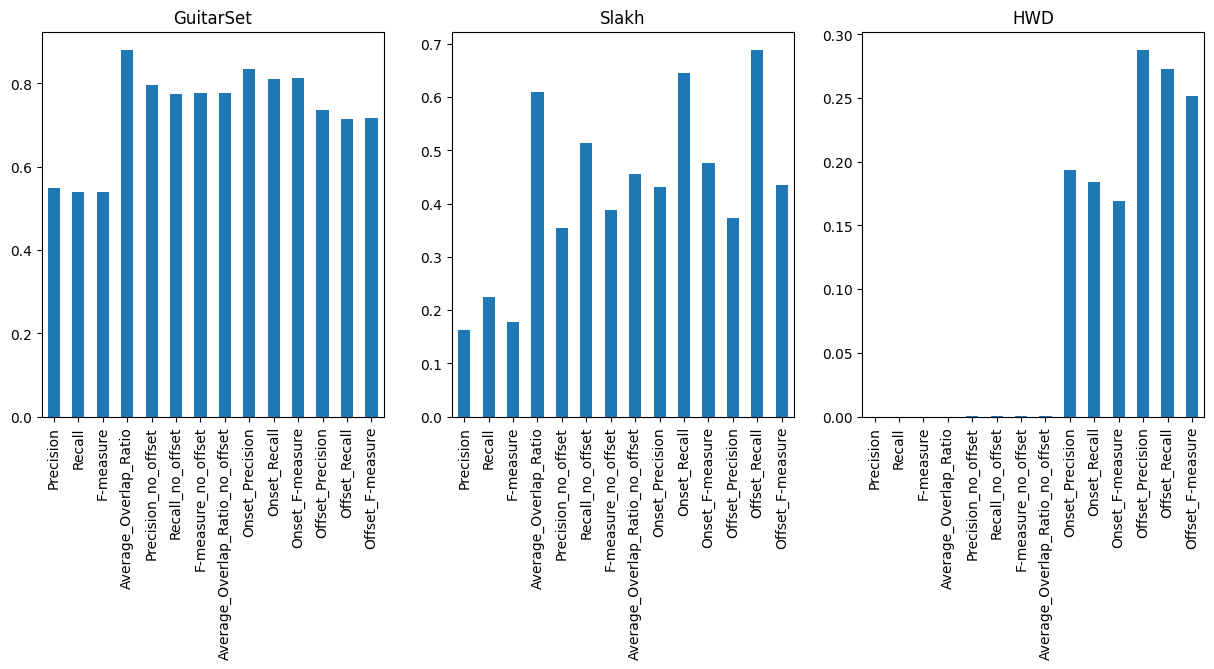

In [110]:
#plot the precision recall f-measure score for each dataset taking into account only the mean
import matplotlib.pyplot as plt


fig, ax = plt.subplots(1, 3, figsize=(15, 5))

guitarset_b.describe().loc['mean'].plot(kind='bar', ax=ax[0], title='GuitarSet')
slakh_b.describe().loc['mean'].plot(kind='bar', ax=ax[1], title='Slakh')
hwd_b.describe().loc['mean'].plot(kind='bar', ax=ax[2], title='HWD')


In [111]:



# load all the json files in my_models
def load_json_files(path):

    data = pd.DataFrame()
    for root, _, files in os.walk(path):
        for file in files:
            if file.endswith('.json'):
                with open(os.path.join(root, file)) as f:
                    data=pd.concat([data,pd.read_json(f, orient='index')])
    return data


data= load_json_files('../My_models')
data

,instrument,Precision,Recall,F-measure,Average_Overlap_Ratio,Precision_no_offset,Recall_no_offset,F-measure_no_offset,Average_Overlap_Ratio_no_offset,Onset_Precision,Onset_Recall,Onset_F-measure,Offset_Precision,Offset_Recall,Offset_F-measure
Potter_Whistle_160_0004,whistle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Potter_Whistle_213_0008,whistle,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.000000,0.032258,0.062500
Potter_Hum_11_0013,hum,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.187500,0.111111,0.139535,0.500000,0.296296,0.372093
Potter_Hum_198_0021,hum,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.230769,0.206897,0.218182,0.346154,0.310345,0.327273
Potter_Hum_82_0025,hum,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.294118,0.172414,0.217391,0.294118,0.172414,0.217391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Track00013-S06,Synth Lead,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Track00015-S03,Strings (continued),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Track00016-S00,Piano,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Track00016-S02,Guitar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [112]:
data.describe()

,Precision,Recall,F-measure,Average_Overlap_Ratio,Precision_no_offset,Recall_no_offset,F-measure_no_offset,Average_Overlap_Ratio_no_offset,Onset_Precision,Onset_Recall,Onset_F-measure,Offset_Precision,Offset_Recall,Offset_F-measure
count,2188.000000,2188.000000,2188.000000,2188.000000,2188.000000,2188.000000,2188.000000,2188.000000,2188.000000,2188.000000,2188.000000,2188.000000,2188.000000,2188.000000
mean,0.023676,0.017448,0.019493,0.052825,0.043658,0.029137,0.033313,0.041202,0.225819,0.124363,0.145511,0.335903,0.190251,0.218375
std,0.106736,0.083494,0.090818,0.206310,0.175559,0.123053,0.137355,0.161989,0.210310,0.133109,0.145171,0.212792,0.152685,0.153544
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.040000,0.057143,0.200000,0.084906,0.114637
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.185185,0.100000,0.117647,0.318182,0.160000,0.200000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.297222,0.160000,0.189128,0.428571,0.265196,0.292683
max,0.822222,0.666667,0.698113,0.957266,1.000000,0.833333,0.844037,0.957266,1.000000,0.843206,0.844037,1.000000,0.971564,0.833333


In [113]:
guitarset = data[data.index.str[0].str.isnumeric()]
slakh = data[data.index.str.startswith('Track')]
hwd = data[~data.index.str[0].str.isnumeric() & ~data.index.str.startswith('Track')]

display(guitarset.describe())
display(slakh.describe())
display(hwd.describe())

,Precision,Recall,F-measure,Average_Overlap_Ratio,Precision_no_offset,Recall_no_offset,F-measure_no_offset,Average_Overlap_Ratio_no_offset,Onset_Precision,Onset_Recall,Onset_F-measure,Offset_Precision,Offset_Recall,Offset_F-measure
count,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000
mean,0.428607,0.287210,0.338348,0.850681,0.778759,0.474388,0.573447,0.648037,0.834947,0.501627,0.608436,0.809589,0.477374,0.581642
std,0.203018,0.181853,0.195020,0.028244,0.107098,0.181941,0.174679,0.125291,0.075384,0.174577,0.160329,0.088523,0.154010,0.136380
min,0.030928,0.004354,0.007634,0.774321,0.550725,0.085631,0.150127,0.285905,0.673077,0.103048,0.180662,0.594203,0.130624,0.229008
25%,0.246914,0.115789,0.183333,0.830523,0.710526,0.347280,0.449848,0.595819,0.790210,0.378049,0.519403,0.750000,0.384921,0.508021
50%,0.450000,0.282609,0.340836,0.849022,0.780000,0.524752,0.614583,0.673010,0.833333,0.548913,0.645833,0.822034,0.495726,0.588235
75%,0.588235,0.415842,0.512397,0.869648,0.855670,0.620253,0.710744,0.737014,0.884058,0.635417,0.730897,0.870968,0.609375,0.682353
max,0.822222,0.606557,0.698113,0.916411,1.000000,0.755814,0.844037,0.832394,1.000000,0.767442,0.844037,0.961538,0.738739,0.811321


,Precision,Recall,F-measure,Average_Overlap_Ratio,Precision_no_offset,Recall_no_offset,F-measure_no_offset,Average_Overlap_Ratio_no_offset,Onset_Precision,Onset_Recall,Onset_F-measure,Offset_Precision,Offset_Recall,Offset_F-measure
count,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000
mean,0.189549,0.181996,0.177525,0.578851,0.366666,0.311639,0.310465,0.474309,0.440670,0.369780,0.368783,0.573354,0.587153,0.548273
std,0.220047,0.224026,0.210167,0.415620,0.301864,0.280559,0.261110,0.322030,0.327004,0.292820,0.271810,0.211344,0.268633,0.214795
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.124579,0.032118,0.051070
25%,0.000000,0.000000,0.000000,0.000000,0.032075,0.031818,0.031545,0.156033,0.077141,0.069693,0.072838,0.456136,0.437185,0.456917
50%,0.045351,0.043750,0.044118,0.857301,0.378753,0.250114,0.294558,0.464658,0.482323,0.333333,0.358333,0.631724,0.670270,0.610526
75%,0.380443,0.335586,0.330729,0.889066,0.606602,0.566742,0.568882,0.767108,0.724723,0.614682,0.619190,0.712016,0.799652,0.700376
max,0.666667,0.666667,0.666667,0.957266,0.992248,0.833333,0.833333,0.957266,1.000000,0.843206,0.833333,1.000000,0.971564,0.833333


,Precision,Recall,F-measure,Average_Overlap_Ratio,Precision_no_offset,Recall_no_offset,F-measure_no_offset,Average_Overlap_Ratio_no_offset,Onset_Precision,Onset_Recall,Onset_F-measure,Offset_Precision,Offset_Recall,Offset_F-measure
count,2032.0,2032.0,2032.0,2032.0,2032.0,2032.0,2032.0,2032.0,2032.000000,2032.000000,2032.000000,2032.000000,2032.000000,2032.000000
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.191279,0.099487,0.117402,0.306861,0.164805,0.191522
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.156494,0.077951,0.084404,0.184858,0.111879,0.113999
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083333,0.037037,0.054054,0.190476,0.080000,0.109091
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.176471,0.093023,0.111111,0.307692,0.153846,0.185450
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.272727,0.153846,0.173913,0.400000,0.241379,0.272727
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.500000,0.483871,1.000000,0.538462,0.564103


<Axes: title={'center': 'HWD'}>

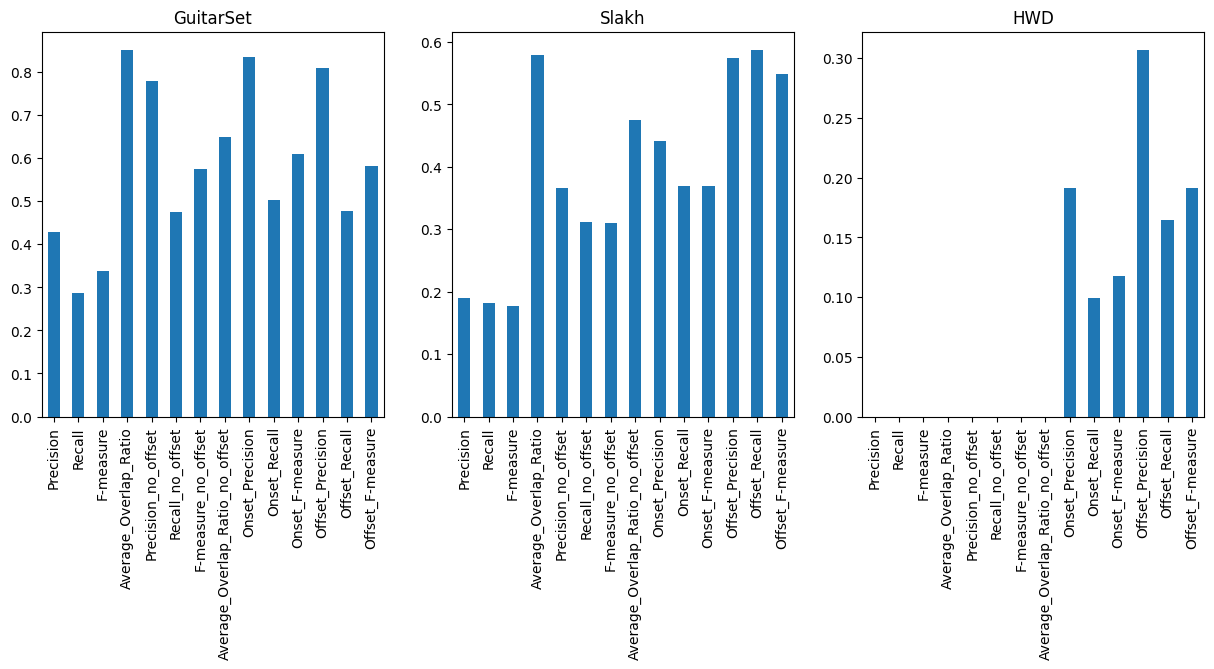

In [114]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

guitarset.describe().loc['mean'].plot(kind='bar', ax=ax[0], title='GuitarSet')
slakh.describe().loc['mean'].plot(kind='bar', ax=ax[1], title='Slakh')
hwd.describe().loc['mean'].plot(kind='bar', ax=ax[2], title='HWD')

<Axes: title={'center': 'Difference'}>

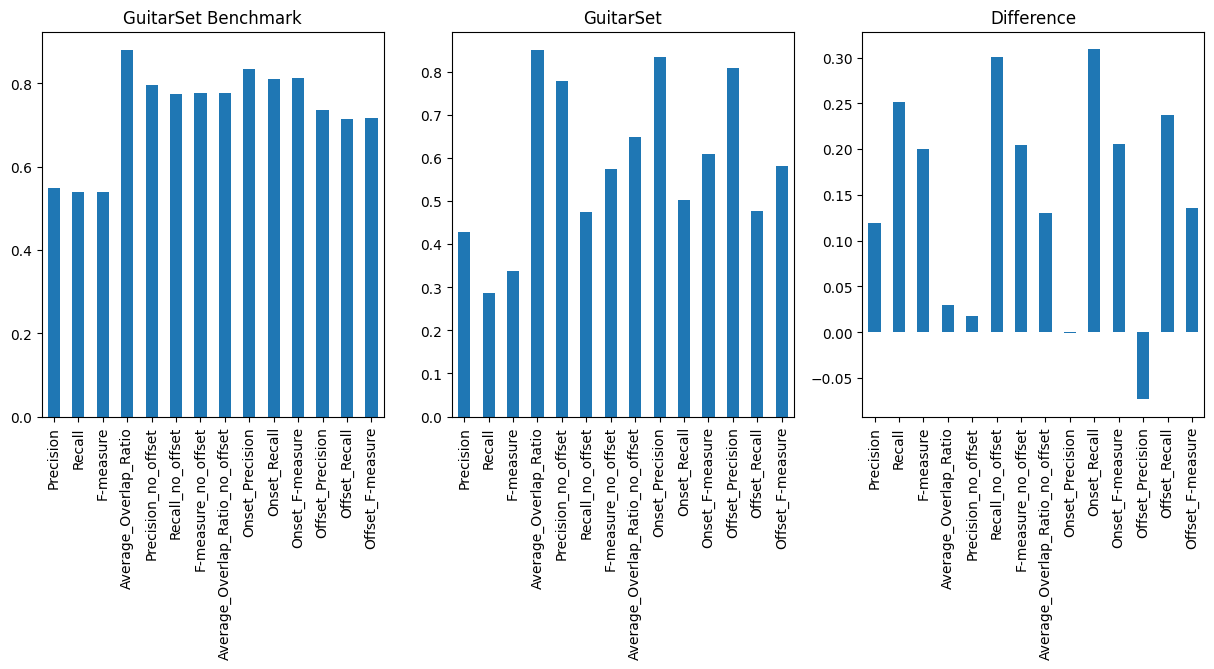

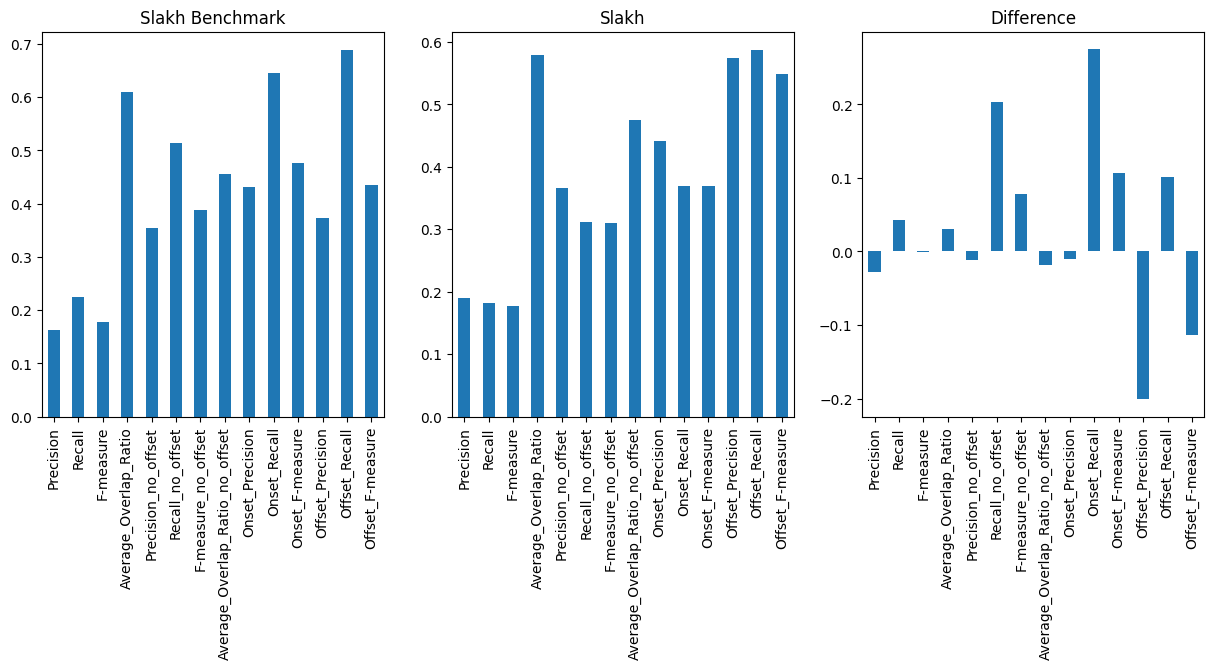

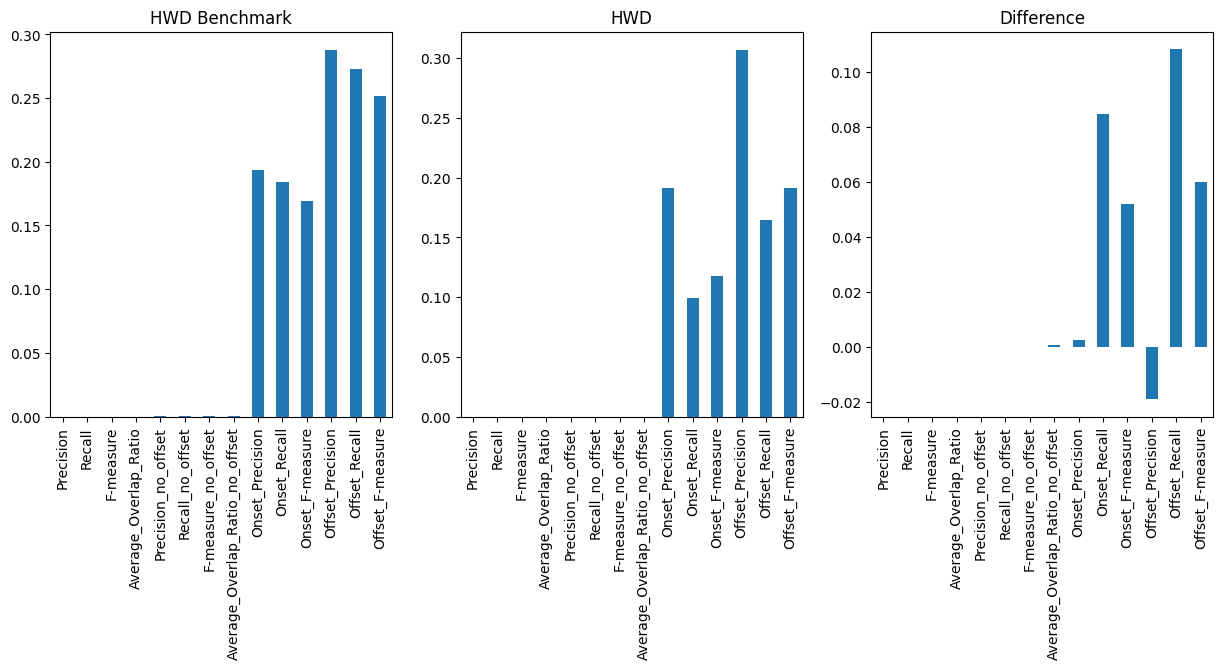

In [118]:
#plot comparison between guitarset and guitarset_b
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

guitarset_b.describe().loc['mean'].plot(kind='bar', ax=ax[0], title='GuitarSet Benchmark')
guitarset.describe().loc['mean'].plot(kind='bar', ax=ax[1], title='GuitarSet')
((guitarset_b).describe().loc['mean']-(guitarset).describe().loc['mean']).plot(kind='bar', ax=ax[2], title='Difference')

#plot comparison between slakh and slakh_b
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

slakh_b.describe().loc['mean'].plot(kind='bar', ax=ax[0], title='Slakh Benchmark')
slakh.describe().loc['mean'].plot(kind='bar', ax=ax[1], title='Slakh')
((slakh_b).describe().loc['mean']-(slakh).describe().loc['mean']).plot(kind='bar', ax=ax[2], title='Difference')

#plot comparison between hwd and hwd_b
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

hwd_b.describe().loc['mean'].plot(kind='bar', ax=ax[0], title='HWD Benchmark')
hwd.describe().loc['mean'].plot(kind='bar', ax=ax[1], title='HWD')
((hwd_b).describe().loc['mean']-(hwd).describe().loc['mean']).plot(kind='bar', ax=ax[2], title='Difference')

